<a href="https://colab.research.google.com/github/RichardHarwood/3D_Clustering/blob/main/3D_Clustering_Simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Single-molecule localization microscopy produces 3D point point clouds (discrete points with XYZ co-ordinates).
<br>

To understand the biological importance of these points we need to understand how they are grouped, that is, how they are clustered.
<br>

To stat lets understand clustering by simulating 3D point clouds
<br>

Firstly, lets just use a Chat-GPT generated code to simulate 3D point clouds



In [18]:
!pip install pyntcloud
!pip install stl
!pip install finder_smlm
!pip install Geometry

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
#Lets look in to Ripleys K functon
def ripley_k_3d(points, r_max, step_size=0.1):
    """
    Calculate Ripley's K-function for 3D point pattern.

    Parameters:
        points (numpy.ndarray): Numpy array of shape (n_points, 3) containing 3D coordinates of the points.
        r_max (float): Maximum distance for which K-function will be computed.
        step_size (float): The step size to compute distances.

    Returns:
        r_values (numpy.ndarray): Array of distances (r) for which K-function is computed.
        k_values (numpy.ndarray): Corresponding Ripley’s K-function values.
    """
    n_points = points.shape[0]

    # Compute pairwise distances
    distances = pdist(points)

    # Create an array of distances from 0 to r_max
    r_values = np.arange(0, r_max, step_size)
    k_values = np.zeros_like(r_values)

    # Calculate K-function for different distance thresholds
    for i, r in enumerate(r_values):
        # Count pairs of points within distance r
        count = np.sum(distances <= r)
        k_values[i] = (count / (n_points * (n_points - 1))) * (n_points / (4/3 * np.pi * r**3))

    return r_values, k_values


# # Generate sample 3D clusters (for demonstration purposes)
# # Cluster 1: Random points in a cube
# cluster_1 = np.random.rand(100, 3) * 10  # 100 points within a 10x10x10 cube

# # Cluster 2: Points distributed in a spherical region
# cluster_2 = np.random.randn(100, 3) * 2 + 5  # 100 points with mean 5 and std 2 in each axis

# # Calculate Ripley's K-function for both clusters
# r_max = 5  # Maximum distance for K-function calculation

# r_1, k_1 = ripley_k_3d(cluster_1, r_max)
# r_2, k_2 = ripley_k_3d(cluster_2, r_max)

# # Plot the K-function for both clusters
# plt.figure(figsize=(10, 6))
# plt.plot(r_1, k_1, label='Cluster 1', color='blue')
# plt.plot(r_2, k_2, label='Cluster 2', color='red')
# plt.xlabel('Distance (r)')
# plt.ylabel('Ripley\'s K-function')
# plt.legend()
# plt.title('Ripley\'s K-function Comparison of 3D Clusters')
# plt.show()

In [20]:
# I also have code that makes outliers and refines how neat the clusters are but I feel Jans will be better
from sklearn.datasets import make_blobs

import numpy as np
import pandas as pd
import tifffile
from scipy.ndimage import label
from skimage.measure import regionprops
import matplotlib.pyplot as plt
from skimage import data, filters, measure, morphology
from tqdm import tqdm
from scipy.spatial import ConvexHull, Delaunay
import sys
import seaborn as sns
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from pyntcloud import PyntCloud
#from stl import mesh
#import pyvista as pv

from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing  import MinMaxScaler
from sklearn.cluster import OPTICS

#organised cluseter function
def generate_clusters(n_clusters, n_points_per_cluster, cluster_std=5.0):
    points = []
    colors = []

    # Define random cluster centers
    cluster_centers = np.random.uniform(0, 100, size=(n_clusters, 3))

    for i in range(n_clusters):
        # Generate random points around the cluster center with some standard deviation
        cluster_points = np.random.normal(loc=cluster_centers[i], scale=cluster_std, size=(n_points_per_cluster, 3))
        points.append(cluster_points)
        colors.append([i] * n_points_per_cluster)

    # Combine all points into a single array
    points = np.vstack(points)
    colors = np.hstack(colors)

    return points, colors, cluster_centers



## Assesing 3D Clustering workflows on simulated data
### Lets start with 3 different types of data
1) Organised clusters - This is data where points are clustered in a way that they are *clearly sepereated* <br>
2) Random clusters - As above but the clusters are more or less random <br>
3) Random data- points are just randomly assinged in XYZ<br>

### FOR NOW LETS USE
n_clusters = 15 <br>
n_points_per_cluster = 20

#### Lets look at data 1  Organised clusters - This is data where points are clustered in a way that they are *clearly sepereated* <br>

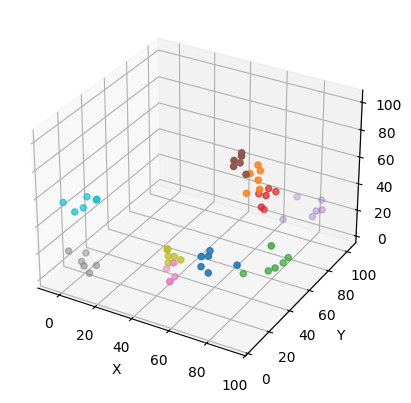

In [21]:
# Parameters for the clusters
n_clusters = 10
n_points_per_cluster = 6
x_width=5
y_width=5
z_width=5

# Generate clusters
points, colors, cluster_centers = generate_clusters(n_clusters, n_points_per_cluster)

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot the points, colored by their respective cluster
scatter = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, cmap='tab10')
# Mark the cluster centers
#ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], cluster_centers[:, 2], c='black', s=100, marker='x', label='Centers')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


# Show plot
plt.show()
d1_eg=points

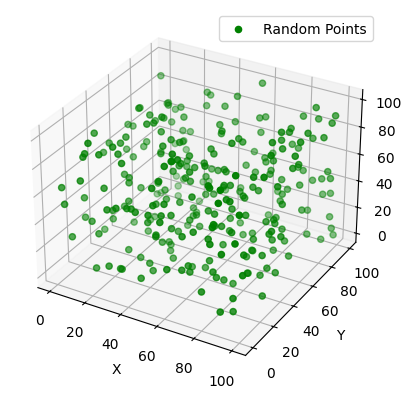

In [22]:
n_points = 300

# Generate random points for x, y, z coordinates
x = np.random.rand(n_points) * 100  # Random points between 0 and 10
y = np.random.rand(n_points) * 100
z = np.random.rand(n_points) * 100

points = np.vstack((x, y, z)).T

# Plotting the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of random points
ax.scatter(x, y, z, c='g', label='Random Points')

# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show legend
ax.legend()

# Display the plot
plt.show()
random_eg=points

<ipython-input-19-c1960aa86293>:31: RuntimeWarning: divide by zero encountered in scalar divide
  k_values[i] = (count / (n_points * (n_points - 1))) * (n_points / (4/3 * np.pi * r**3))
<ipython-input-19-c1960aa86293>:31: RuntimeWarning: invalid value encountered in scalar multiply
  k_values[i] = (count / (n_points * (n_points - 1))) * (n_points / (4/3 * np.pi * r**3))


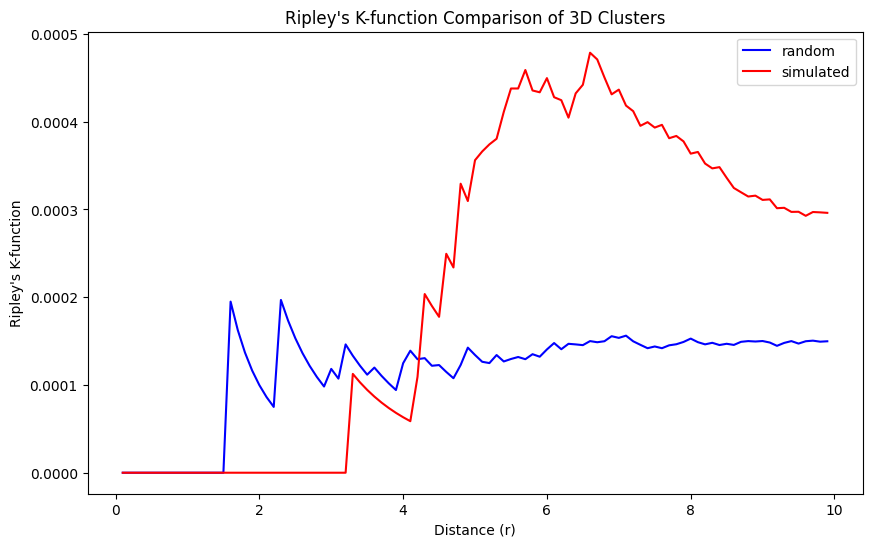

In [23]:
cluster_1=random_eg
cluster_2=d1_eg

# # Calculate Ripley's K-function for both clusters
r_max = 10  # Maximum distance for K-function calculation

r_1, k_1 = ripley_k_3d(cluster_1, r_max)
r_2, k_2 = ripley_k_3d(cluster_2, r_max)

# Plot the K-function for both clusters
plt.figure(figsize=(10, 6))
plt.plot(r_1, k_1, label='random', color='blue')
plt.plot(r_2, k_2, label='simulated', color='red')
plt.xlabel('Distance (r)')
plt.ylabel('Ripley\'s K-function')
plt.legend()
plt.title('Ripley\'s K-function Comparison of 3D Clusters')
plt.show()

## For simplicity lets see how DBSCAN segments the clusters
Essentially we with hold the cluster information for DBSCAN gets an input like this(rember we had 15 clusters)

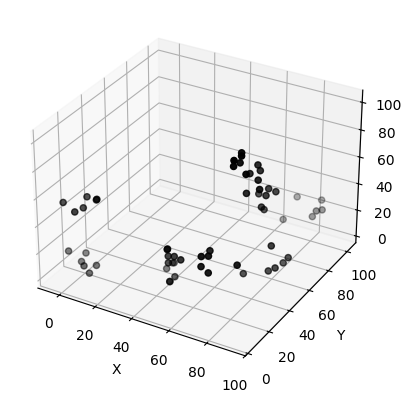

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot the points, colored by their respective cluster
scatter = ax.scatter(d1_eg[:, 0], d1_eg[:, 1], d1_eg[:, 2], c="black")
# Mark the cluster centers
#ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], cluster_centers[:, 2], c='black', s=100, marker='x', label='Centers')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


# Show plot
plt.show()

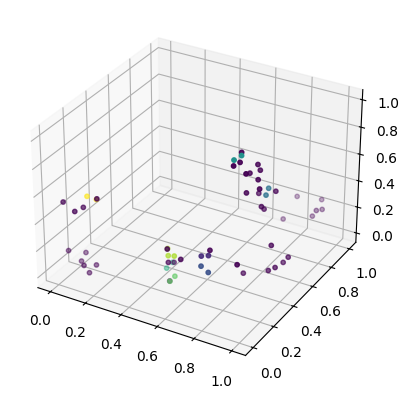

number of cluster found: 9


In [25]:
X=d1_eg
scaler = MinMaxScaler()
scaler.fit(X)
X_norm = scaler.transform(X)
db_df_np=X_norm
#db_df_np=X

model = DBSCAN(eps=0.05, min_samples = 2,leaf_size=2)
pred = model.fit_predict( db_df_np)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(db_df_np[:,0], db_df_np[:,1], db_df_np[:,2], c=model.labels_, s=10)
#ax.view_init(azim=200)
plt.show()

print("number of cluster found: {}".format(len(set(model.labels_))))


## Now lets see how FINDER goes - @ Jan can you populate your code ?


In [26]:
from finder import Finder
FD = Finder() # define the model
labels = FD.fit(db_df_np) # fit the data, returning the labels
result = FD.selected_parameters
print(result)

Analysing 60 points
Boundaries for sigma    : 0.20999275406108825 , 0.503849715890513
Sigmas are:
[0.20999275 0.2235394  0.23795993 0.25331074 0.26965183 0.28704708
 0.3055645  0.32527648 0.34626008 0.36859734 0.39237557 0.41768774
 0.44463279 0.47331607 0.50384972]
Thresholds are:
[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Computing clusters : 0.99 seconds
Postprocessing..
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Computing similarity scores: 3.91 seconds
Selected threshold , sigma : 7 , 0.25331074026716943
Comp time Step 1 (set boundaries): 0.02 seconds
Comp time Step 2 (clustering): 0.99 seconds
Comp time Step 3 (postprocessing): 4.13 seconds
Selected parameters: {'sigma': 0.25331074026716943, 'threshold': 7}
{'sigma': 0.25331074026716943, 'threshold': 7}


In [27]:
## I DUNNO HOW TO PLOT THE FINDER RESULTS ?
